# Projection and Sparse Grid Methods for Continuous-Time Neoclassical Growth Model

This notebook solves the continuous-time neoclassical growth model using **projection (collocation)** methods in two ways:

1. **Chebyshev projection**: approximate $V(k)$ with Chebyshev polynomials and set the HJB residual to zero at collocation nodes.
2. **Sparse grid**: an optimization of projection that uses **nested** collocation points (e.g. Clenshaw–Curtis). In 1D this gives a hierarchical grid; in higher dimensions sparse grids use many fewer points than a full tensor product.

## Model (same as other notebooks)

- **State**: capital $k(t)$  
- **Control**: consumption $c(t)$  
- **HJB**: $\rho V(k) = \max_c \{ u(c) + V'(k)\, [f(k) - \delta k - c] \}$  
- **Production**: $f(k) = k^\alpha$, **Utility**: $u(c) = c^{1-\gamma}/(1-\gamma)$ (or $\log c$ if $\gamma=1$)  
- **FOC**: $c = (V'(k))^{-1/\gamma}$

## Imports and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve
from scipy.interpolate import interp1d, CubicSpline
from numpy.polynomial import chebyshev as C

np.random.seed(42)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

# Same parameters as Neoclass-growth-model.ipynb
rho = 0.05
alpha = 0.3
delta = 0.1
gamma = 2.0
k_min, k_max = 0.1, 10.0

print("Model parameters: rho={}, alpha={}, delta={}, gamma={}".format(rho, alpha, delta, gamma))
print("Capital range: [{}, {}]".format(k_min, k_max))

Model parameters: rho=0.05, alpha=0.3, delta=0.1, gamma=2.0
Capital range: [0.1, 10.0]


## Map $k \in [k_{\min}, k_{\max}]$ to $x \in [-1, 1]$ for Chebyshev

Chebyshev polynomials are defined on $[-1,1]$. We use $x = \frac{2k - (k_{\min}+k_{\max})}{k_{\max}-k_{\min}}$ so $k = \frac{(k_{\max}-k_{\min}) x + (k_{\min}+k_{\max})}{2}$.

In [2]:
def k_to_x(k):
    return (2.0 * k - (k_min + k_max)) / (k_max - k_min)

def x_to_k(x):
    return ((k_max - k_min) * x + (k_min + k_max)) / 2.0

# Collocation: use Chebyshev nodes in [-1,1], then map to k
def chebyshev_nodes(n):
    """ n+1 Chebyshev nodes (roots of T_{n+1}), in [-1,1] """
    return np.cos(np.pi * (np.arange(n + 1) + 0.5) / (n + 1))

def collocation_k_nodes(n):
    x = chebyshev_nodes(n)
    return x_to_k(x)

## Model primitives and HJB residual

Given coefficients `coef` for $V(k) \approx \sum_j c_j T_j(x(k))$, we compute value, derivative, optimal consumption, and HJB residual.

In [3]:
def production(k):
    return np.power(k, alpha)

def utility(c):
    if gamma == 1.0:
        return np.log(np.maximum(c, 1e-10))
    return (np.maximum(c, 1e-10) ** (1 - gamma)) / (1 - gamma)

def consumption_from_foc(dV_dk):
    dV_dk = np.maximum(dV_dk, 1e-10)
    return np.power(dV_dk, -1.0 / gamma)

# V(k) = sum_j coef[j] * T_j(x(k)); dV/dk = (dV/dx)(dx/dk)
# dx/dk = 2/(k_max - k_min)
dx_dk = 2.0 / (k_max - k_min)

def value_and_derivative(coef, k):
    x = k_to_x(k)
    V = C.chebval(x, coef)
    dV_dx = C.chebder(coef, 1)
    dV_dk = C.chebval(x, dV_dx) * dx_dk
    return V, dV_dk

def hjb_residual_at_k(coef, k):
    V, dV_dk = value_and_derivative(coef, k)
    c = consumption_from_foc(dV_dk)
    f_k = production(k)
    dk_dt = f_k - delta * k - c
    u_c = utility(c)
    lhs = rho * V
    rhs = u_c + dV_dk * dk_dt
    return lhs - rhs

## Part 1: Chebyshev projection (collocation)

We have $n+1$ coefficients and $n+1$ collocation nodes. Require residual $R(k_i; \theta) = 0$ at each node $k_i$. This is a nonlinear system in $\theta$; we solve it with `scipy.optimize.root`.

In [4]:
def collocation_system(coef, k_nodes):
    """ Residual at each collocation point (for root solver). """
    return np.array([hjb_residual_at_k(coef, ki) for ki in k_nodes])

def solve_projection(n_degree, tol=1e-10):
    """
    n_degree: degree of Chebyshev polynomial (n_degree+1 coefficients, n_degree+1 nodes)
    """
    n = n_degree + 1  # number of nodes = number of coefs
    k_nodes = collocation_k_nodes(n_degree)
    # Initial guess: small constant value function
    coef0 = np.zeros(n)
    coef0[0] = 1.0  # T_0(x)=1 so V ~ 1
    
    sol = root(collocation_system, coef0, args=(k_nodes,), method='hybr', tol=tol)
    if not sol.success:
        print("Warning: root finder:", sol.message)
    return sol.x, k_nodes

n_degree = 12   # Higher degree = more collocation nodes, more precise
coef, k_nodes = solve_projection(n_degree)
print("Chebyshev coefficients (degree {}):".format(n_degree))
print(coef)
print("Collocation nodes (k):", k_nodes.round(4))

 improvement from the last ten iterations.
Chebyshev coefficients (degree 12):
[-2.00004623e-04  6.70105880e-15 -5.22810535e-21 -5.71078361e-21
  6.59604628e-22 -1.52517104e-21  1.61646082e-22  4.41736219e-23
  2.46039058e-23 -4.66181773e-22  1.41869568e-23 -5.65057066e-23
 -3.54518923e-24]
Collocation nodes (k): [9.9639 9.6783 9.1238 8.3325 7.3504 6.2346 5.05   3.8654 2.7496 1.7675
 0.9762 0.4217 0.1361]


## Evaluate solution on a fine grid and plot

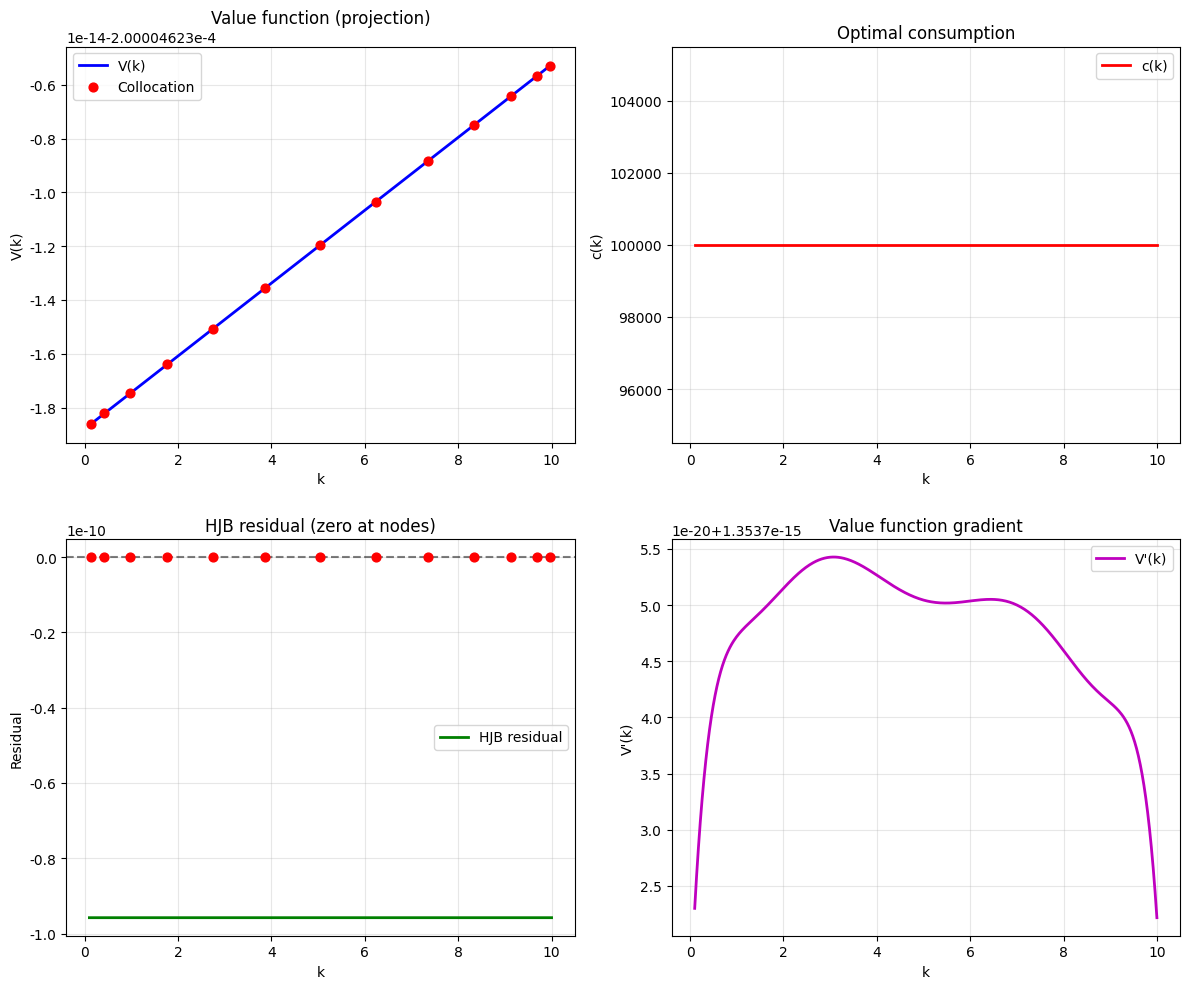

In [5]:
def evaluate_solution(coef, k_fine):
    x_fine = k_to_x(k_fine)
    V_fine = C.chebval(x_fine, coef)
    dV_dx = C.chebder(coef, 1)
    dV_dk_fine = C.chebval(x_fine, dV_dx) * dx_dk
    c_fine = consumption_from_foc(dV_dk_fine)
    res_fine = np.array([hjb_residual_at_k(coef, ki) for ki in k_fine])
    return V_fine, dV_dk_fine, c_fine, res_fine

k_fine = np.linspace(k_min, k_max, 500)
V_fine, dV_dk_fine, c_fine, res_fine = evaluate_solution(coef, k_fine)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(k_fine, V_fine, 'b-', lw=2, label='V(k)')
axes[0, 0].scatter(k_nodes, C.chebval(k_to_x(k_nodes), coef), color='red', s=40, zorder=5, label='Collocation')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('V(k)')
axes[0, 0].set_title('Value function (projection)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(k_fine, c_fine, 'r-', lw=2, label='c(k)')
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('c(k)')
axes[0, 1].set_title('Optimal consumption')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(k_fine, res_fine, 'g-', lw=2, label='HJB residual')
axes[1, 0].axhline(0, color='k', ls='--', alpha=0.5)
axes[1, 0].scatter(k_nodes, np.zeros_like(k_nodes), color='red', s=40, zorder=5)
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('HJB residual (zero at nodes)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(k_fine, dV_dk_fine, 'm-', lw=2, label="V'(k)")
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel("V'(k)")
axes[1, 1].set_title('Value function gradient')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Check residual norm

Max and mean absolute residual on the fine grid (collocation only forces zero at nodes).

In [6]:
print("Max |residual| on fine grid:", np.max(np.abs(res_fine)))
print("Mean |residual| on fine grid:", np.mean(np.abs(res_fine)))
print("Residual at collocation nodes (should be ~0):", np.abs(collocation_system(coef, k_nodes)))

Max |residual| on fine grid: 9.577939194358061e-11
Mean |residual| on fine grid: 9.577724221414711e-11
Residual at collocation nodes (should be ~0): [9.57791820e-11 9.57781434e-11 9.57776302e-11 9.57773900e-11
 9.57770061e-11 9.57769707e-11 9.57770756e-11 9.57768828e-11
 9.57768152e-11 9.57771413e-11 9.57773791e-11 9.57779949e-11
 9.57790961e-11]


---
## Part 2: Sparse grid (optimized projection)

Sparse grids use **nested** collocation points so that in high dimensions the number of points grows more slowly than a full tensor product. Here in 1D we use **Clenshaw–Curtis** nodes at a given level $\ell$ ($n_\ell = 2^\ell + 1$ points). The value function is approximated by **spline interpolation** over the grid values; unknowns are $V_i$ at each $k_i$. We require the HJB residual to be zero at these points.

In [7]:
def clenshaw_curtis_nodes_1d(level):
    """Nested Clenshaw-Curtis points. Level ell: 2^ell + 1 points."""
    n = 2**level + 1 if level >= 1 else 2
    i = np.arange(n)
    x = np.cos(np.pi * i / max(n - 1, 1))
    k = ((k_max - k_min) * (x + 1) / 2.0) + k_min
    return np.sort(k)

def sparse_grid_1d(level):
    """In 1D, sparse grid = Clenshaw-Curtis points at this level."""
    return clenshaw_curtis_nodes_1d(level)

level_sg = 6   # Level 6 -> 65 points (higher = denser sparse grid)
k_grid_sg = sparse_grid_1d(level_sg)
print("Sparse grid level =", level_sg, "->", len(k_grid_sg), "points")
print("k range:", k_grid_sg[0].round(4), "...", k_grid_sg[-1].round(4))

Sparse grid level = 6 -> 65 points
k range: 0.1 ... 10.0


### HJB residual for sparse grid (spline-based $V$)

We use the same `production`, `utility`, `consumption_from_foc` as above. Here $V$ is given by grid values and cubic spline interpolation; the residual is evaluated at the grid points.

In [8]:
def hjb_residual_at_points(V_values, k_points, kind='cubic'):
    """HJB residual at k_points given V_values (spline interpolant)."""
    k_points = np.asarray(k_points)
    V_values = np.asarray(V_values)
    if kind == 'linear':
        interp = interp1d(k_points, V_values, kind='linear', fill_value='extrapolate')
        dV = np.gradient(V_values, k_points)
    else:
        cs = CubicSpline(k_points, V_values)
        interp = cs
        dV = cs(k_points, 1)
    V_at = interp(k_points)
    c_at = consumption_from_foc(dV)
    f_k = production(k_points)
    dk_dt = f_k - delta * k_points - c_at
    u_c = utility(c_at)
    return rho * V_at - (u_c + dV * dk_dt)

def sparse_grid_system(V_flat, k_grid):
    """Residual at each sparse grid point (for root solver)."""
    return hjb_residual_at_points(V_flat, k_grid, kind='cubic')

In [9]:
def solve_sparse_grid(level, tol=1e-9):
    k_grid = sparse_grid_1d(level)
    n = len(k_grid)
    V0 = 2.0 * np.log(k_grid + 0.5)
    sol = root(sparse_grid_system, V0, args=(k_grid,), method='hybr', tol=tol)
    if not sol.success:
        print("Warning:", sol.message)
    return sol.x, k_grid

V_grid_sg, k_grid_sg = solve_sparse_grid(level_sg)
print("Sparse grid solution: V at first/last points:", V_grid_sg[0].round(4), V_grid_sg[-1].round(4))

 improvement from the last ten iterations.
Sparse grid solution: V at first/last points: -1.0217 4.7028


### Evaluate sparse grid solution on a fine grid and plot

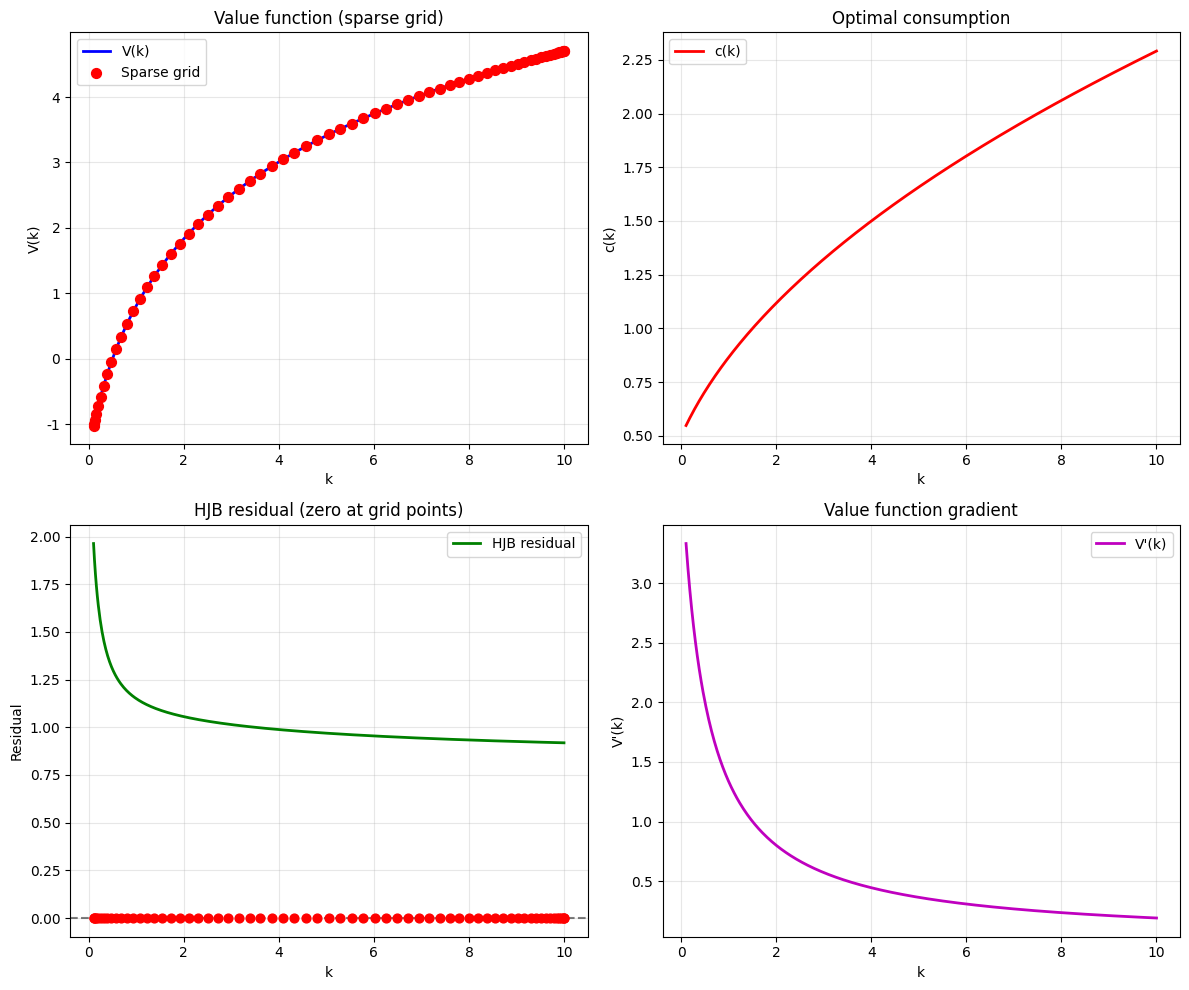

In [10]:
def evaluate_sparse_grid_on_fine(V_grid, k_grid, k_fine):
    cs = CubicSpline(k_grid, V_grid)
    V_fine = cs(k_fine)
    dV_fine = cs(k_fine, 1)
    c_fine = consumption_from_foc(dV_fine)
    f_f = production(k_fine)
    dk_f = f_f - delta * k_fine - c_fine
    res_fine = rho * V_fine - (utility(c_fine) + dV_fine * dk_f)
    return V_fine, dV_fine, c_fine, res_fine

k_fine_sg = np.linspace(k_min, k_max, 500)
V_fine_sg, dV_fine_sg, c_fine_sg, res_fine_sg = evaluate_sparse_grid_on_fine(V_grid_sg, k_grid_sg, k_fine_sg)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].plot(k_fine_sg, V_fine_sg, 'b-', lw=2, label='V(k)')
axes[0, 0].scatter(k_grid_sg, V_grid_sg, color='red', s=50, zorder=5, label='Sparse grid')
axes[0, 0].set_xlabel('k'); axes[0, 0].set_ylabel('V(k)'); axes[0, 0].set_title('Value function (sparse grid)')
axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(k_fine_sg, c_fine_sg, 'r-', lw=2, label='c(k)')
axes[0, 1].set_xlabel('k'); axes[0, 1].set_ylabel('c(k)'); axes[0, 1].set_title('Optimal consumption')
axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(k_fine_sg, res_fine_sg, 'g-', lw=2, label='HJB residual')
axes[1, 0].axhline(0, color='k', ls='--', alpha=0.5)
axes[1, 0].scatter(k_grid_sg, np.zeros(len(k_grid_sg)), color='red', s=40, zorder=5)
axes[1, 0].set_xlabel('k'); axes[1, 0].set_ylabel('Residual'); axes[1, 0].set_title('HJB residual (zero at grid points)')
axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].plot(k_fine_sg, dV_fine_sg, 'm-', lw=2, label="V'(k)")
axes[1, 1].set_xlabel('k'); axes[1, 1].set_ylabel("V'(k)"); axes[1, 1].set_title('Value function gradient')
axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
res_at_grid_sg = sparse_grid_system(V_grid_sg, k_grid_sg)
print("Sparse grid: max |residual| on fine grid:", np.max(np.abs(res_fine_sg)).round(6))
print("Sparse grid: max |residual| at grid points:", np.max(np.abs(res_at_grid_sg)).round(6))

Sparse grid: max |residual| on fine grid: 1.96311
Sparse grid: max |residual| at grid points: 1.96311
